In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, Delaunay
from matplotlib.colors import Normalize
from matplotlib.path import Path
plt.rcParams['figure.dpi'] = 120
plt.rcParams['lines.markerfacecolor'] = 'lime'
plt.rcParams['lines.markeredgecolor'] = 'lime'


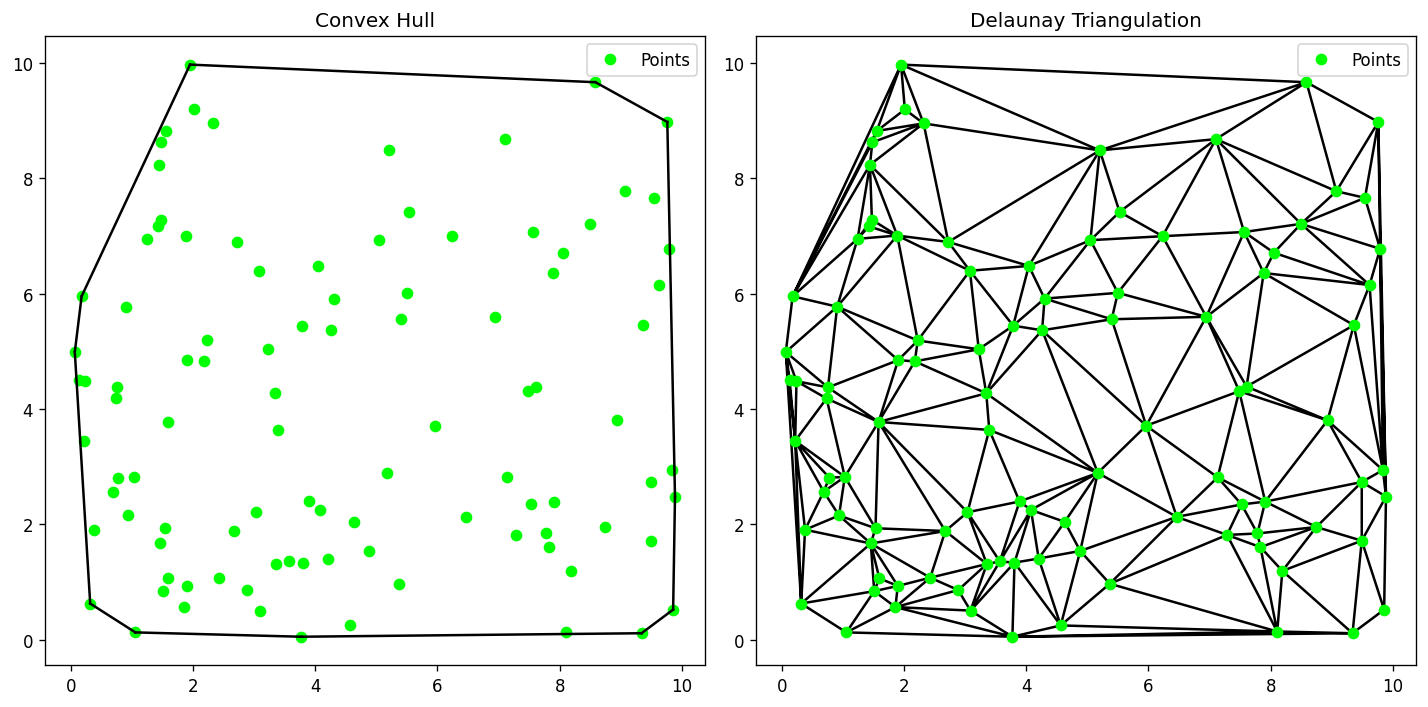

In [14]:
# Prob 3(a)
fp = r'C:\Users\Eric\Desktop\PHYS 129AL\PS2\Code\mesh .dat'
points = np.loadtxt(fp, skiprows=1)


hull = ConvexHull(points)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].plot(points[:, 0], points[:, 1], 'o', label='Points',color='lime')
for simplex in ConvexHull(points).simplices:
    axes[0].plot(points[simplex, 0], points[simplex, 1], 'k-')
axes[0].set_title("Convex Hull")
axes[0].legend()

tri = Delaunay(points)
axes[1].triplot(points[:, 0], points[:, 1], tri.simplices, 'k-')
axes[1].plot(points[:, 0], points[:, 1], 'o', label='Points')
axes[1].set_title("Delaunay Triangulation")
axes[1].legend()

plt.tight_layout()
plt.show()


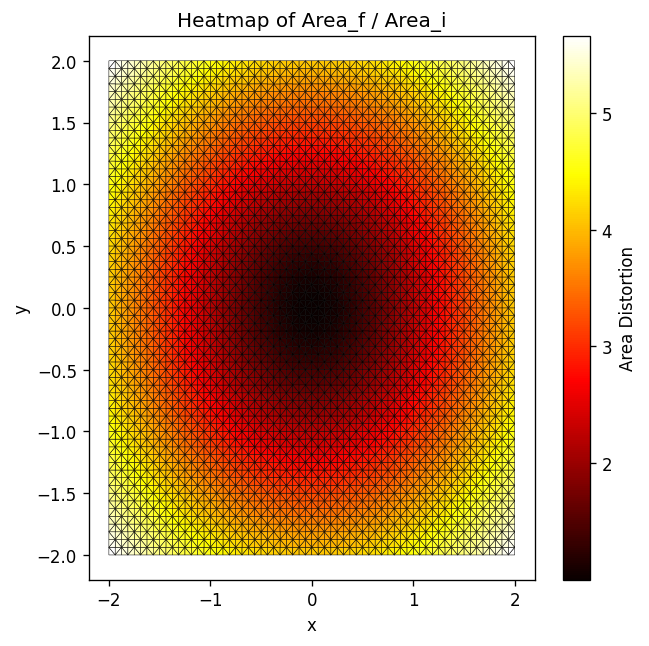

In [65]:
# Prob 3(b)

def lifting_map(x,y):
    return x**2+y**2
def triangle_area(p1, p2, p3):
    return 0.5 * np.linalg.norm(np.cross(p2 - p1, p3 - p1))

# Mesh this surface
mesh = 65
x_vals = np.linspace(-2, 2, mesh)  
y_vals = np.linspace(-2, 2, mesh)  
X, Y = np.meshgrid(x_vals, y_vals)
points = np.column_stack((X.ravel(), Y.ravel()))
Z = lifting_map(points[:, 0], points[:, 1])


# Try to apply the Delaunay traiangle to this lifted mesh
tri = Delaunay(points)

# Map the 2D points to 3D
area_change = []
for simplex in tri.simplices:
    p1, p2, p3 = points[simplex]  # Original (x, y) points
    p1_lifted = np.array([p1[0], p1[1], lifting_map(p1[0], p1[1])])
    p2_lifted = np.array([p2[0], p2[1], lifting_map(p2[0], p2[1])])
    p3_lifted = np.array([p3[0], p3[1], lifting_map(p3[0], p3[1])])
    area_original = triangle_area(np.array([p1[0], p1[1], 0]), np.array([p2[0], p2[1], 0]), np.array([p3[0], p3[1], 0]))
    area_lifted = triangle_area(p1_lifted, p2_lifted, p3_lifted)
    area_change.append((area_lifted) / area_original )

# Plot
plt.figure(figsize=(6, 6))
plt.tripcolor(points[:, 0], points[:, 1], tri.simplices, facecolors=area_change, cmap='hot', edgecolors='k',linewidth=.3)
plt.colorbar(label="Area Distortion")
plt.title("Heatmap of Area_f / Area_i")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


In [50]:
# Prob 3(c)
def induced_metric_analytic(x, y):
    g_11 = 1 + (2 * x) ** 2
    g_12 = (2 * x) * (2 * y)
    g_22 = 1 + (2 * y) ** 2
    return np.array([[g_11, g_12], [g_12, g_22]])


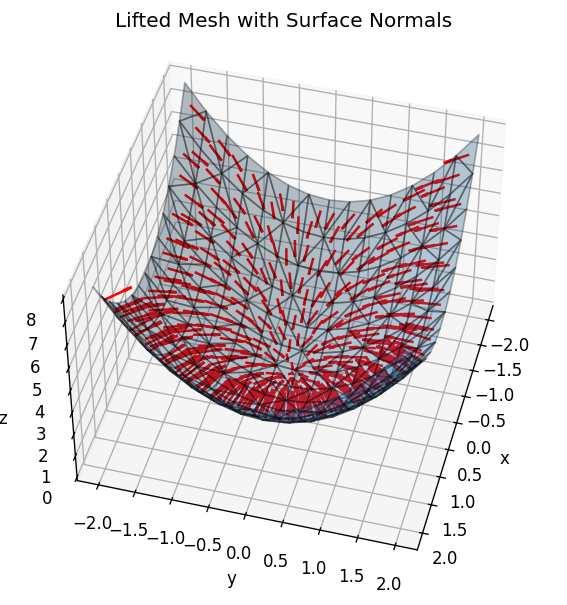

In [67]:
# Prob 3(d)
mesh=15
x_vals = np.linspace(-2, 2, mesh)
y_vals = np.linspace(-2, 2, mesh)
X, Y = np.meshgrid(x_vals, y_vals)
points = np.column_stack((X.ravel(), Y.ravel()))
Z = points[:, 0]**2 + points[:, 1]**2
tri = Delaunay(points[:, :2])
def compute_normal(tri_coord):
    v1, v2, v3 = tri_coord
    edge1 = v2 - v1
    edge2 = v3 - v1
    normal = np.cross(edge1, edge2)
    return normal / np.linalg.norm(normal)  
normals = np.array([compute_normal(np.array([
    [points[i][0], points[i][1], Z[i]] for i in simplex
])) for simplex in tri.simplices])

centers = np.array([
    np.mean([[points[i][0], points[i][1], Z[i]] for i in simplex], axis=0)
    for simplex in tri.simplices
])
fig = plt.figure(figsize=(8, 6),dpi=120)
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(points[:, 0], points[:, 1], Z, triangles=tri.simplices, alpha=0.3, edgecolor='k')
ax.quiver(
    centers[:, 0], centers[:, 1], centers[:, 2],  
    normals[:, 0], normals[:, 1], normals[:, 2], 
    length=0.4, color='red'
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.view_init(elev=45, azim=15)
ax.set_title("Lifted Mesh with Surface Normals")

plt.show()

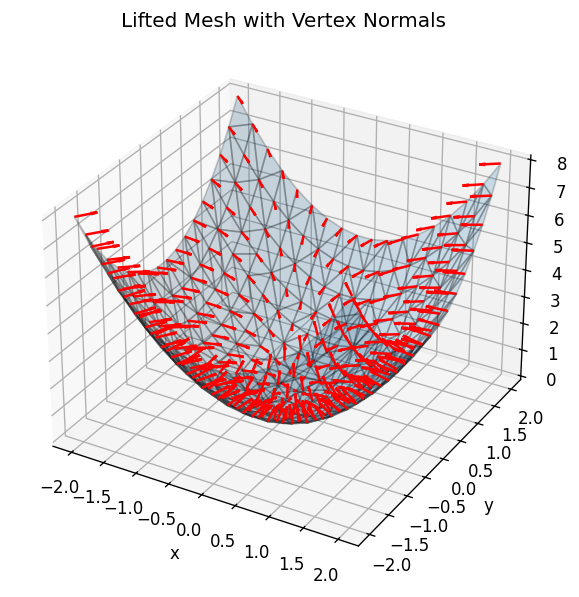

In [ ]:
# Prob 3(e)
def compute_normal_and_area(tri_coord):
    v1, v2, v3 = tri_coord
    edge1 = v2 - v1
    edge2 = v3 - v1
    normal = np.cross(edge1, edge2)
    area = 0.5 * np.linalg.norm(normal)  # Triangle area
    return normal / np.linalg.norm(normal), area  # Return normalized normal and area



mesh=18
x_vals = np.linspace(-2, 2, mesh)
y_vals = np.linspace(-2, 2, mesh)
X, Y = np.meshgrid(x_vals, y_vals)
points = np.column_stack((X.ravel(), Y.ravel()))
Z = points[:, 0]**2 + points[:, 1]**2
tri = Delaunay(points[:, :2])



tri_normals = []
tri_areas = []
for simplex in tri.simplices:
    tri_coord = np.array([[points[i][0], points[i][1], Z[i]] for i in simplex])
    normal, area = compute_normal_and_area(tri_coord)
    tri_normals.append(normal)
    tri_areas.append(area)

tri_normals = np.array(tri_normals)
tri_areas = np.array(tri_areas)

vertex_normals = np.zeros((len(points), 3))  
vertex_contributions = np.zeros(len(points)) 
for i, simplex in enumerate(tri.simplices):
    for vertex in simplex:
        vertex_normals[vertex] += tri_normals[i] * tri_areas[i]  
        vertex_contributions[vertex] += tri_areas[i]  # Sum of weights

vertex_normals /= vertex_contributions[:, np.newaxis]  # Normalize per vertex

# Plot surface and vertex normals
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(points[:, 0], points[:, 1], Z, triangles=tri.simplices, alpha=0.2, edgecolor='k')
ax.quiver(
    points[:, 0], points[:, 1], Z,  
    vertex_normals[:, 0], vertex_normals[:, 1], vertex_normals[:, 2],  
    length=0.3, color='red'
)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("Lifted Mesh with Vertex Normals")

plt.show()

In [72]:
# Prob 3(f)

# Extract x, y coordinates
x = points[:, 0]
y = points[:, 1]

partial_xx = np.array([np.full_like(x, 0), np.full_like(x, 0), np.full_like(x, 2)]).T
partial_yy = np.array([np.full_like(y, 0), np.full_like(y, 0), np.full_like(y, 2)]).T
partial_xy = np.array([np.full_like(x, 0), np.full_like(x, 0), np.full_like(x, 0)]).T

A = (partial_xx * vertex_normals).sum(axis=1)  # A = N ⋅ ∂²f/∂x²
B = (partial_xy * vertex_normals).sum(axis=1)  # B = N ⋅ ∂²f/∂x∂y
C = B  # Since second derivatives are symmetric
D = (partial_yy * vertex_normals).sum(axis=1)  # D = N ⋅ ∂²f/∂y²

matrix = np.stack([A, B, C, D], axis=-1).reshape(-1, 2, 2)

# Print example output for a vertex
index = 0  # Change index to check other points
print(f"Second Fundamental Form at vertex {index}:")
print(f"A = {A[index]}")
print(f"B = {B[index]}")
print(f"C = {C[index]}")
print(f"D = {D[index]}")


Second Fundamental Form at vertex 0:
A = 0.36919463843853795
B = 0.0
C = 0.0
D = 0.36919463843853795


<function print>

In [ ]:
g) Calculate the shape operator for all vertexes on the lifted surface numerically (look at the lecture notes). Calculate the principle, Gaussian, mean
curvatures for those points and visualize them. Hint: you need to diagonalize a
2 by 2 matrix at each point